<a href="https://colab.research.google.com/github/imshivs/congressional-analysis/blob/master/Congressional_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

As we saw in the introductory class, there is a relationship between level of income and political affiliations. In this notebook we will test if education acts as a mediator for affiliations and Income levels 

# Hypothesis 

We believe education is a mediator variable that explains the relationship between income and party affiliation. This is our assumption because in every day life, education seems to be an important component in hiring, and therefore it has a direct relationship to how much one earns. We conducted an exploratory analysis in three steps to test whether education explains the process through which income and party affiliation are perhaps related.

### Data Collection & Cleaning

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd 
import statistics
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import warnings

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

In [ ]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01003_001E,B06009_002E,B06009_004E,B06009_005E,B06009_006E,B19001_017E,B19001_001E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Population','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'State code','district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['District Name','Population','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'district number', 'State']]


In [ ]:
# converting columns to numeric
acs_df["Population"] = pd.to_numeric(acs_df["Population"])
acs_df["less than high school"] = pd.to_numeric(acs_df["less than high school"])
acs_df["high school"] = pd.to_numeric(acs_df["high school"])
acs_df["some college"] = pd.to_numeric(acs_df["some college"])
acs_df["bachelors degree"] = pd.to_numeric(acs_df["bachelors degree"])
acs_df["graduate or professional degree"] = pd.to_numeric(acs_df["graduate or professional degree"])
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
#acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

In [ ]:
# Data Wrangling 
acs_df['No college'] = acs_df['less than high school'] + acs_df['high school'] #+ acs_df["some college"]
acs_df['Bachelors or higher'] = acs_df['bachelors degree'] + acs_df['graduate or professional degree']
#acs_df['Graduate or professional'] = acs_df["graduate or professional degree"]  

In [ ]:
# Converting to percentages
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of population no college'] = (100*acs_df['No college'])/acs_df['Population']
#acs_df['% of population bachelors'] = (100*acs_df['Bachelors'])/acs_df['Population']
acs_df['% of population bachelors'] = (100*acs_df["bachelors degree"])/acs_df['Population']
acs_df['% of population graduate or professional degree'] = (100*acs_df["graduate or professional degree"])/acs_df['Population']
acs_df['% of population some college'] = (100*acs_df["some college"])/acs_df['Population']
acs_df['% of population bachelors or higher'] = acs_df['% of population graduate or professional degree'] + acs_df['% of population bachelors'] + acs_df['% of population some college']
#acs_df.head()

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]


In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])
final_merged_df = merged_df[['% of population no college','% of population some college','% of population bachelors','% of population graduate or professional degree', '% of population bachelors or higher', 'Party', '% of households over $200k']]
final_merged_df

,% of population no college,% of population some college,% of population bachelors,% of population graduate or professional degree,% of population bachelors or higher,Party,% of households over $200k
0,28.718895,10.594623,7.058051,1.636312,19.288987,R,4.181493
1,28.684537,9.651692,6.216427,1.544543,17.412662,R,3.977417
2,29.951074,10.108105,6.916824,1.311196,18.336125,R,3.405150
3,31.228794,8.172390,5.270192,1.420684,14.863267,R,3.797889
4,27.269494,15.037014,9.957554,3.163039,28.157607,R,7.833083
...,...,...,...,...,...,...,...
430,24.379129,19.543116,9.121892,3.952348,32.617357,R,9.440648
431,27.056175,13.346326,6.465682,2.419353,22.231361,R,5.800476
432,29.305836,12.311105,6.019601,2.260851,20.591557,R,5.337775
433,25.871313,14.694480,5.968740,2.341823,23.005043,R,5.666663


# Part 1: The Relationship between Education and Party Affiliation

In part one of our testing, we look at relationship between education and party affiliations, based on this density plot of population without college degree, both the plots are slightly skewed. The percentage of population without any college degree is more concentrated in republican districts which is centered around approximately 25-27%
In case of % population with bachelor’s degree more concentrated in democratic districts and lastly, for graduate and professional degree, both the plots are skewed to left but the percentage of population is more concentrated in democratic districts. 


In [ ]:
colors = {'R': '#FF0000', 'D': '#0015BC', 'L': '#FFFF00'}

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Plot % of population with no college degree')

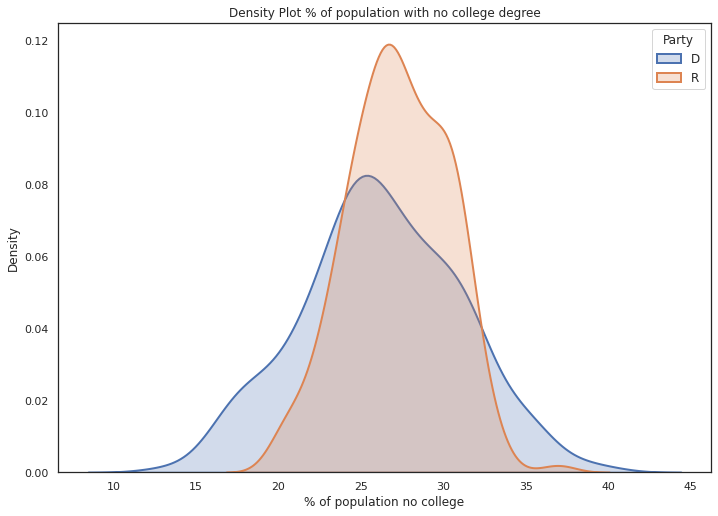

In [ ]:
# List of Party
Party = ['D', 'R']

# Iterate through Party
for Party in Party:
    # Subset
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% of population no college'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')
plt.title('Density Plot % of population with no college degree')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


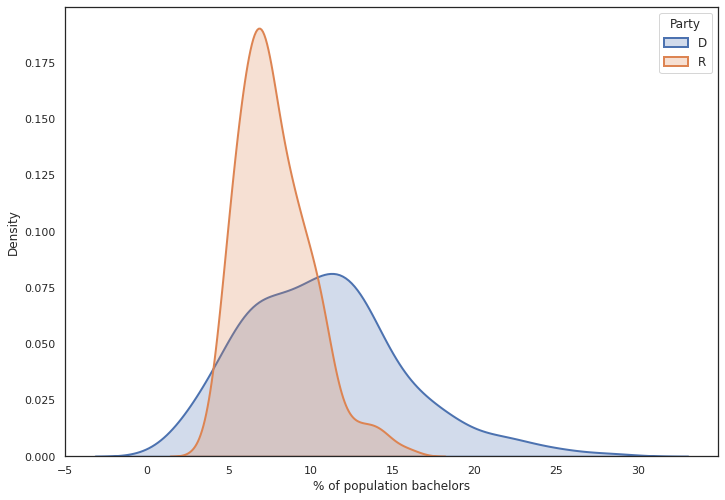

In [ ]:
Party = ['D', 'R']

# Iterate through the party
for Party in Party:
    # Subset 
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% of population bachelors'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


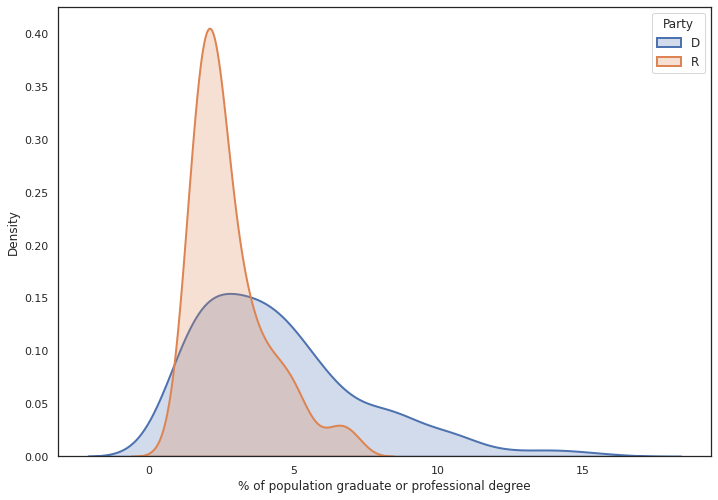

In [ ]:
Party = ['D', 'R']

# Iterate through Party
for Party in Party:
    # Subset 
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% of population graduate or professional degree'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')


# Part 2: The Relationship between Income and Education

The scatter plot belows shows a positive correlation between the proporation of the US population with a college education and the proportion of households earning 200K dollars or higher. We also see that in highly education districts where 20% or more households make over $200K, elected officials tend to be democrats. The second scatterplot shows a negative correlation between the proportion of the US population that never attended college vs the prorportion of households earning 200K dollars or higher.


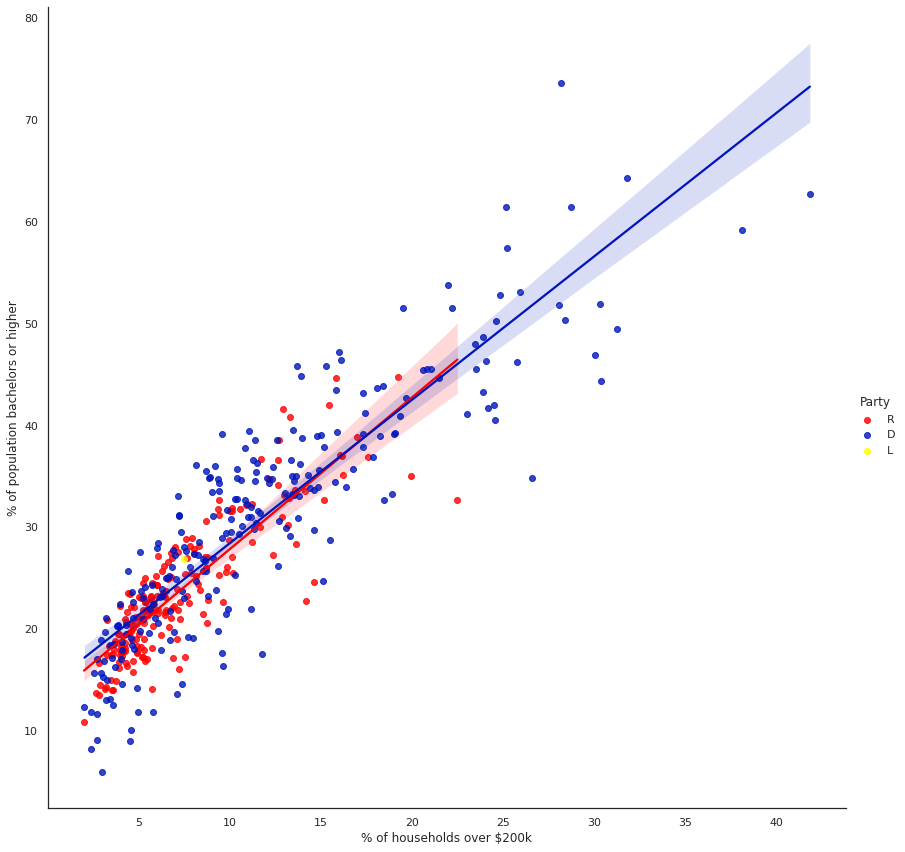

In [ ]:
R = merged_df.where((merged_df['Party'].str.contains('R')))
D = merged_df.where((merged_df['Party'].str.contains('D'))) 

sns.lmplot(x="% of households over $200k", y="% of population bachelors or higher", hue = 'Party', data=final_merged_df, palette = colors, height=12);
rcParams['figure.figsize'] = 15,8.27


**Pearson's Coefficient - Republicans (Bachelors or Higher vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% of population bachelors or higher', '% of households over $200k']]
R_1 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_1 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_1.corr(method="pearson")

,% of population bachelors or higher,% of households over $200k
% of population bachelors or higher,1.000000,0.856179
% of households over $200k,0.856179,1.000000


**Pearson's Coefficient - Democrats (Bachelors or Higher vs. Households over $200k)**

In [ ]:
D_1.corr(method="pearson")

,% of population bachelors or higher,% of households over $200k
% of population bachelors or higher,1.000000,0.884097
% of households over $200k,0.884097,1.000000


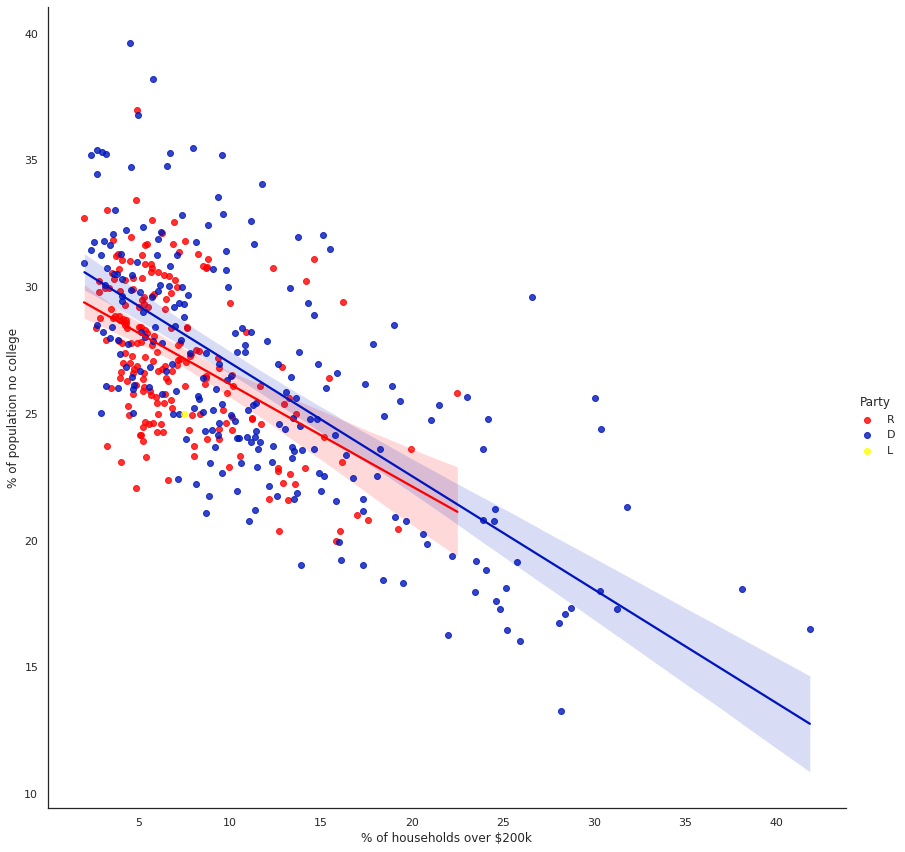

In [ ]:
sns.lmplot(x="% of households over $200k", y="% of population no college", hue = 'Party', data=final_merged_df, palette = colors, height=12);
rcParams['figure.figsize'] = 15,8.27

**Pearson's Coefficient - Republicans (No Education vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% of population no college', '% of households over $200k']]
R_2 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_2 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_2.corr(method="pearson")

,% of population no college,% of households over $200k
% of population no college,1.000000,-0.493731
% of households over $200k,-0.493731,1.000000


**Pearson's Coefficient - Democrats (No Education vs. Households over $200k)**

In [ ]:
D_2.corr(method="pearson")

,% of population no college,% of households over $200k
% of population no college,1.000000,-0.697406
% of households over $200k,-0.697406,1.000000


# Part 3: Plotting Varying Levels of Education vs Income

The follower scatterplots show varying levels of education vs % of households earning over 200K dollars. There seems to be positive correlation between income and education in all three cases. The relationship seems to be the strongest in the first scatterplot, where the correlation between % of population with a graduate or professional degree and % of population earning over 200K dollars is nearly 1. 1 indicates a perfectly positive linear correlation and -1 indicates a perfectly negative linear correlation.


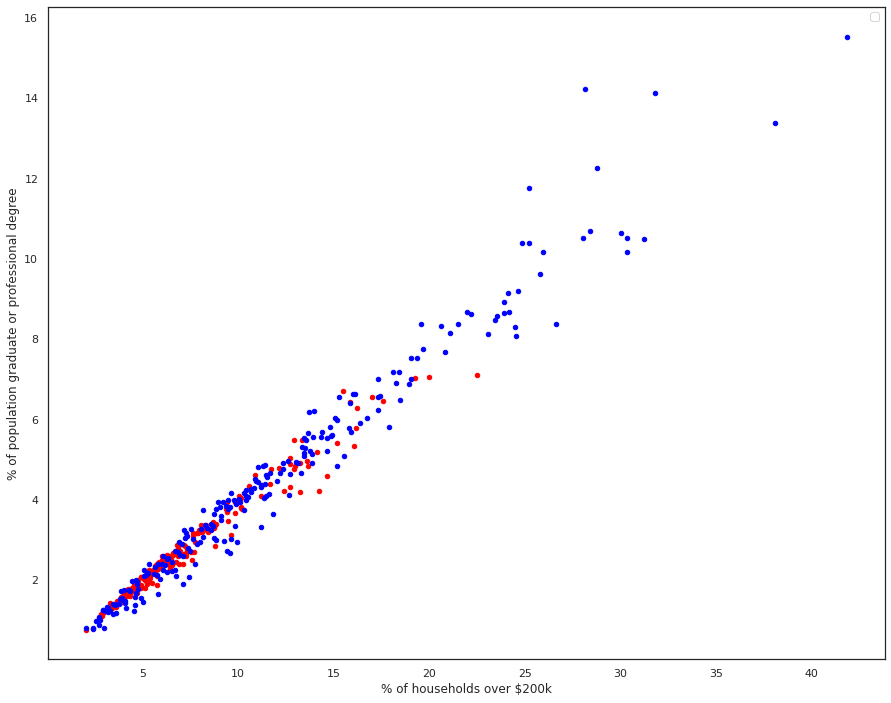

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

R.plot.scatter(x='% of households over $200k', y='% of population graduate or professional degree', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of population graduate or professional degree', c='blue', ax=ax)


plt.legend()
plt.show()

**Pearson's Coefficient - Republicans (Graduate or Professional vs. Households over $200k)**

In [86]:
pearson_df = merged_df[['% of population graduate or professional degree', '% of households over $200k']]

R_3 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_3 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_3.corr(method="pearson"))

,% of population graduate or professional degree,% of households over $200k
% of population graduate or professional degree,1.000000,0.984604
% of households over $200k,0.984604,1.000000


**Pearson's Coefficient - Democrats (Graduate Degree or Higher vs. Households over $200k)**

In [87]:
D_3.corr()

,% of population graduate or professional degree,% of households over $200k
% of population graduate or professional degree,1.000000,0.983309
% of households over $200k,0.983309,1.000000


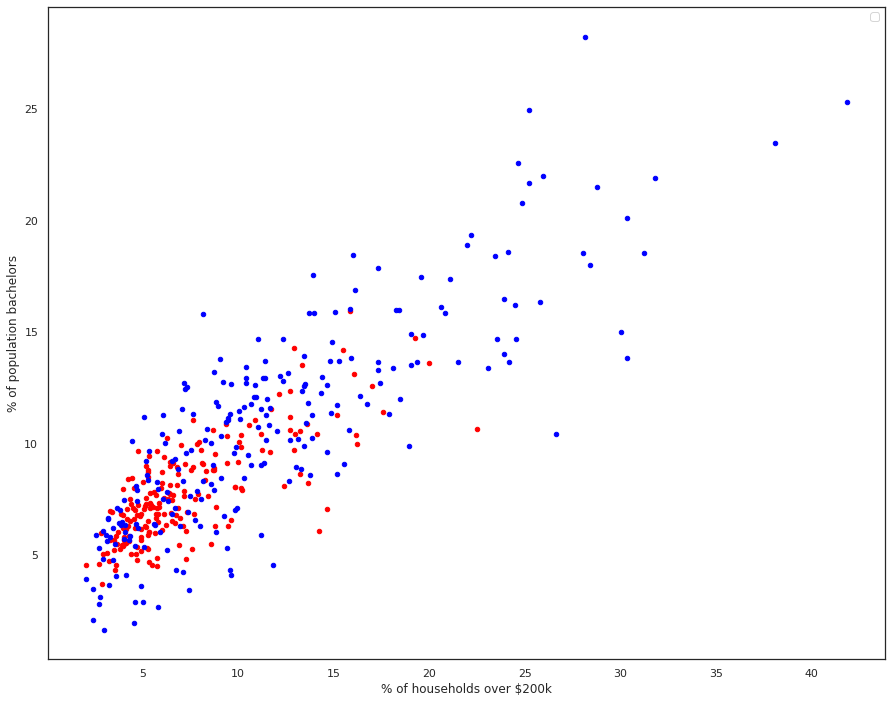

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of population bachelors', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of population bachelors', c='blue', ax=ax)

plt.legend()
plt.show()

**Pearson's Coefficient - Republicans (Bachelors Degree vs. Households over $200k)**

In [88]:
pearson_df = merged_df[['% of population bachelors', '% of households over $200k']]

R_4 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_4 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_4.corr(method="pearson"))

,% of population bachelors,% of households over $200k
% of population bachelors,1.000000,0.758083
% of households over $200k,0.758083,1.000000


**Pearson's Coefficient - Democrats (Bachelors Degree vs. Households over $200k)**

In [89]:
D_4.corr(method="pearson"))

,% of population bachelors,% of households over $200k
% of population bachelors,1.000000,0.837424
% of households over $200k,0.837424,1.000000


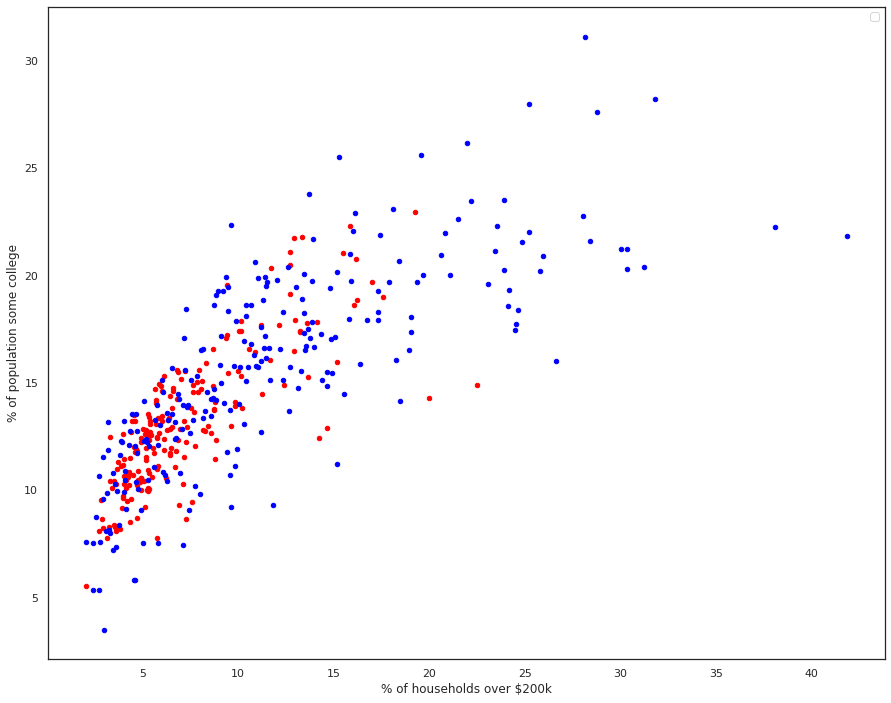

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

R.plot.scatter(x='% of households over $200k', y='% of population some college', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of population some college', c='blue', ax=ax)

plt.legend()
plt.show()


**Pearson's Coefficient - Republicans (Some College vs. Households over $200k)**

In [90]:
pearson_df = merged_df[['% of population some college', '% of households over $200k']]

R_5 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_5 = pearson_df.where((merged_df['Party'].str.contains('D')))

R_5.corr(method="pearson"))

,% of population some college,% of households over $200k
% of population some college,1.00000,0.78518
% of households over $200k,0.78518,1.00000


**Pearson's Coefficient - Democrats (Some College vs. Households over $200k)**

In [ ]:
D_5.corr(method="pearson"))

# Conclusion

Education seems to be correlated with income and it also seems to have some relationship with party affiliation. The correlation matrixes allow us to numerically compare the correlation between income and education - does it differ at different levels of education and does it differ for democrats and republication? In almost all cases (except for % of population with graduation or professional degrees), democrats seemed to have a stronger correlation between high income and level of education. For those with a graduation of professional degree, the correlation between education and high income was almost the same regardless of party affiliation.